In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import numpy as np

import os
import json
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Step 1: VOCSegmentation 데이터셋 로드 및 클래스 정보 설정하기

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        """
        VOCSegmentation 데이터셋을 로드하고, 이미지와 pixel-level segmentation mask를 반환하는 Dataset 클래스입니다.

        Args:
            root (str): 데이터셋이 저장될 루트 경로
            train (bool): True이면 training 데이터를, False이면 validation 데이터를 사용
            transform: 입력 이미지에 적용할 변환(예: 크기 조정, tensor 변환 등)
            target_transform: segmentation mask에 적용할 변환(보통 크기 조정 등, 클래스 값 보존을 위해 nearest interpolation 사용)
            download (bool): 데이터가 없으면 자동으로 다운로드할지 여부
        """
        # train이면 'train', 아니면 'val' 이미지를 선택합니다.
        image_set = 'train' if train else 'val'

        # torchvision의 VOCSegmentation 클래스를 사용하여 VOC 데이터셋을 불러옵니다.
        self.voc = datasets.VOCSegmentation(
            root=root,
            year='2012',
            image_set=image_set,
            download=download
        )
        
        # VOC 데이터셋 내의 클래스 정보를 담고 있는 JSON 파일 경로를 지정합니다.
        classes_json_path = os.path.join(root, "VOCdevkit", "VOC2012", "classes.json")
        if os.path.exists(classes_json_path):
            # JSON 파일이 있으면 불러와서 카테고리 정보를 저장합니다.
            with open(classes_json_path, "r") as file:
                self.categories = json.load(file)
        else:
            # JSON 파일이 없는 경우 기본값을 사용합니다.
            # 1번부터 21번까지의 클래스(보통 background가 0이고 1~20은 객체 클래스)를 만듭니다.
            self.categories = {str(i): {"class": f"class_{i}",
                                        "color": [i * 10 % 256, i * 20 % 256, i * 30 % 256]}
                               for i in range(1, 22)}
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        """
        데이터셋에 포함된 샘플의 총 개수를 반환합니다.
        """
        return len(self.voc)
    
    def __getitem__(self, index):
        # VOCSegmentation 객체로부터 image와 mask를 불러옵니다.
        image, mask = self.voc[index]
        
        # mask는 PIL.Image 형태로 로드되므로 numpy 배열로 변환하여 각 픽셀 값을 확인할 수 있습니다.
        mask = np.array(mask)
        
        # VOC 마스크에서는 255가 'ignore label'(배경)로 사용됩니다.
        # 모델 학습 시 ignore label은 보통 처리하지 않으므로, 여기서는 0 (배경)으로 대체합니다.
        mask = np.where(mask == 255, 0, mask)
        
        # numpy 배열을 파이토치의 LongTensor로 변환합니다.
        # unsqueeze(0)은 마스크에 채널 차원을 추가하여 (H, W) --> (1, H, W) 형태로 만듭니다.
        target = torch.LongTensor(mask).unsqueeze(0)

        # 입력 이미지에 설정된 transform(예: 크기 조정, tensor 변환 등)을 적용합니다.
        if self.transform is not None:
            image = self.transform(image)
        # 마스크에도 target_transform이 있다면 적용합니다.
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

# Step 2: 이미지와 마스크에 적용할 전처리(Transform) 정의하기

In [8]:
# 이미지 변환:
# 1. PIL 이미지를 tensor로 변환
# 2. tensor의 데이터 타입을 float로 변경
# 3. 이미지 크기를 (224, 224)로 조정
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224))
])

# 마스크 변환:
# 마스크는 정수값(클래스 id)을 가지므로, 크기 조정 시 nearest interpolation을 사용하여 값이 보존되도록 합니다.
target_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)
])

# Step 3: 데이터셋과 DataLoader 생성하기

In [12]:
# 데이터셋 경로 (VOC 데이터셋의 루트 폴더)
root = "/Users/carki/Desktop/Dev/codeit/common/data"

# train 데이터셋 생성 (필요시 download=True 옵션 사용)
train_dataset = SegmentationDataset(root=root, 
                                    train=True, 
                                    transform=transform, 
                                    target_transform=target_transform, 
                                    download=True)
# test 또는 validation 데이터셋 생성
test_dataset = SegmentationDataset(root=root, 
                                   train=False, 
                                   transform=transform, 
                                   target_transform=target_transform, 
                                   download=False)

# DataLoader 생성: 데이터를 배치 단위로 불러와 학습에 사용할 수 있도록 합니다.
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=4, 
                              shuffle=True, 
                              drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=2, 
                             shuffle=True, 
                             drop_last=True)

# Step 4: 시각화 함수 정의하기

In [13]:
def draw_mask(images, masks, outputs=None, plot_size=4):
    """
    학습 중 또는 결과 확인을 위해, 이미지와 segmentation mask를 시각화합니다.

    Args:
        images (Tensor): 배치 이미지 (shape: [B, C, H, W])
        masks (Tensor): 배치 마스크 (shape: [B, 1, H, W])
        outputs (Tensor, optional): 예측 마스크 (있을 경우)
        plot_size (int): 시각화할 배치의 수
    """
    # 내부 함수: 마스크에 클래스별 색상을 입히는 함수
    def color_mask(image, target):
        # target: (1, H, W) 텐서를 squeeze하여 (H, W) 형태로 변경
        m = target.squeeze().numpy().astype(np.uint8)
        # image와 같은 크기를 가지는 빈 컬러 이미지를 생성 (H, W, 3)
        cm = np.zeros_like(image, dtype=np.uint8)
        # 클래스 1~20에 대해 색상 적용 (background는 0으로 남음)
        for i in range(1, 21):
            cm[m == i] = train_dataset.categories.get(str(i), {"color": [0, 0, 0]})["color"]
        # 마스크에 포함된 클래스 번호를 이용해 클래스 이름 리스트 생성
        classes = [train_dataset.categories.get(str(idx), {"class": f"class_{idx}"})["class"] for idx in np.unique(m)]
        return cm, classes

    # 출력할 열 수: 예측 결과(outputs)가 있으면 3, 없으면 2
    col = 3 if outputs is not None else 2
    # figsize: outputs가 있으면 8, 없으면 12 (원하는 크기에 맞춰 조절 가능)
    figsize = 8 if outputs is not None else 12
    fig, ax = plt.subplots(plot_size, col, figsize=(14, figsize), constrained_layout=True)

    for batch in range(plot_size):
        # 이미지 tensor를 numpy 배열로 변환 후, (C, H, W) -> (H, W, C) 형태로 전환
        im = images[batch].numpy().transpose(1, 2, 0)
        ax[batch][0].imshow(im)
        ax[batch][0].set_title("Original Image")
        ax[batch][0].axis("off")

        # 실제 마스크를 색칠한 결과
        cm, classes = color_mask(im, masks[batch])
        ax[batch][1].set_title("GT Mask\n" + " / ".join(classes))
        ax[batch][1].imshow(cm)
        ax[batch][1].axis("off")

        # 만약 예측 결과가 있다면 추가로 시각화
        if outputs is not None:
            cm, classes = color_mask(im, outputs[batch])
            ax[batch][2].set_title("Pred Mask\n" + " / ".join(classes))
            ax[batch][2].imshow(cm)
            ax[batch][2].axis("off")
    plt.show()

# Step 5: DataLoader에서 한 배치 가져와 시각화하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


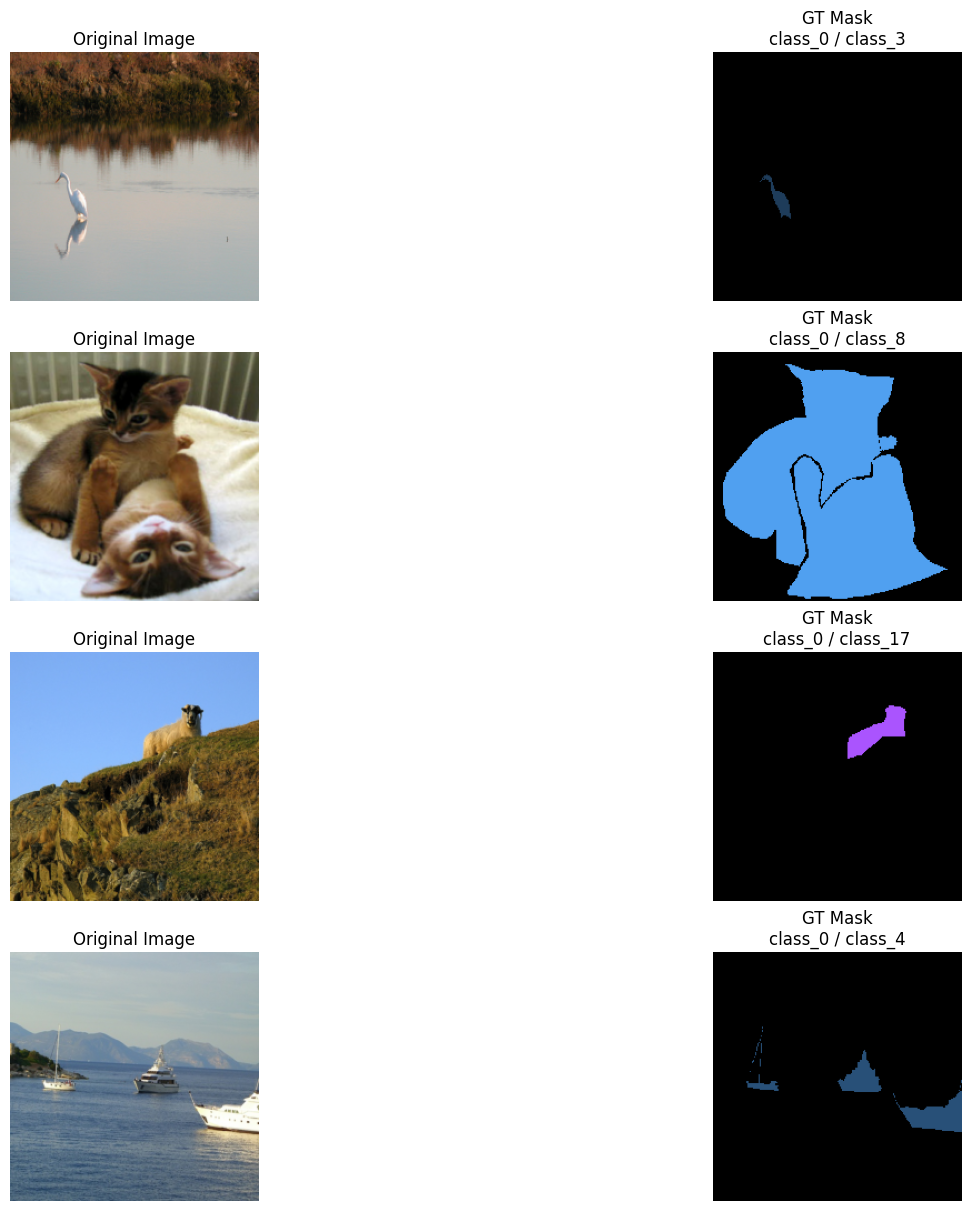

In [16]:
# train DataLoader에서 한 배치를 가져옵니다.
images, masks = next(iter(train_dataloader))
# 첫 배치의 결과를 시각화하여 데이터 로드와 전처리 과정이 올바르게 작동하는지 확인합니다.
draw_mask(images, masks, plot_size=4)

# FCN-8s 모델 정의 (VGG16 백본 사용)

In [10]:
class FCN8s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN8s, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        features = list(vgg16.features.children())
        print(f'[DEV_LOG]\nFeatures: {features}')

        self.pool3 = nn.Sequential(*features[:17])      # (약 1/8 해상도)
        self.pool4 = nn.Sequential(*features[17:24])    # (약 1/16 해상도)
        self.pool5 = nn.Sequential(*features[24:])      # (약 1/32 해상도)

        # 28 x 28
        self.score_pool3 = nn.Conv2d(in_channels=256,
                                     out_channels=num_classes, 
                                     kernel_size=1)
        # 14 x 14
        self.score_pool4 = nn.Conv2d(in_channels=512, 
                                     out_channels=num_classes, 
                                     kernel_size=1)
        # 7 x 7
        self.score_fr    = nn.Conv2d(in_channels=512, 
                                     out_channels=num_classes, 
                                     kernel_size=1)
        
        # Transposed convolution (upsampling) layers
        # O = (i-1) * S + K -2P

        # score_fr (1/32 해상도) -> upsample x2 -> 1/16 해상도
        # i*2+4-2 --> (7-1)*2+4-2 = 12+2 = 14
        self.upscore2 = nn.ConvTranspose2d(num_classes, 
                                           num_classes, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1, 
                                           bias=False)
        # fuse_pool4 (1/16 해상도) -> upsample x2 -> 1/8 해상도
        # i*2+4-2 --> (14-1)*2+4-2 = 26+2 = 28
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, 
                                                num_classes, 
                                                kernel_size=4, 
                                                stride=2, 
                                                padding=1, 
                                                bias=False)
        # fuse_pool3 (1/8 해상도) -> upsample x8 -> 원본 해상도
        # i*2+4-2 --> (28-1)*8+16-8 = 216+8 = 224
        self.upscore8 = nn.ConvTranspose2d(num_classes,
                                           num_classes, 
                                           kernel_size=16, 
                                           stride=8, 
                                           padding=4, 
                                           bias=False)
        
    def forward(self, x):
        input_size = x.size()  # [B, C, H, W]
        pool3 = self.pool3(x)  # 1/8 해상도, 채널: 256
        pool4 = self.pool4(pool3)  # 1/16 해상도, 채널: 512
        pool5 = self.pool5(pool4)  # 1/32 해상도, 채널: 512
        
        # [B, num_classes, H/32, W/32]
        score_fr = self.score_fr(pool5)
        # upsample x2 -> [B, num_classes, H/16, W/16]
        upscore2 = self.upscore2(score_fr)  

        # [B, num_classes, H/16, W/16]
        score_pool4 = self.score_pool4(pool4)
        # skip connection  
        fuse_pool4 = upscore2 + score_pool4  

        # upsample x2 -> [B, num_classes, H/8, W/8]
        upscore_pool4 = self.upscore_pool4(fuse_pool4)  

        # [B, num_classes, H/8, W/8]
        score_pool3 = self.score_pool3(pool3)  
        # skip connection
        fuse_pool3 = upscore_pool4 + score_pool3  

        # upsample x8 -> [B, num_classes, H, W]
        upscore8 = self.upscore8(fuse_pool3)  

        # 입력 크기와 정확히 맞지 않을 경우, crop하여 맞춥니다.
        out = upscore8[:, :, :input_size[2], :input_size[3]]
        return out
        

# 하이퍼파라미터 및 디바이스 설정

In [17]:
num_classes = 21
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FCN8s(num_classes=num_classes).to(device)

/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[DEV_LOG]
Features: [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(

# 옵티마이저와 손실 함수 설정

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss() # 분류라서 CrossEntropyLoss 사용

# 학습 loop (tqdm으로 진행 상황 표시)

In [24]:
num_epochs = 10# 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        targets = targets.to(device)  # targets shape: [B, H, W]

        # 타겟의 차원 확인 후 squeeze
        if targets.dim() == 4 and targets.size(1) == 1:
            targets = targets.squeeze(1)


        optimizer.zero_grad()
        outputs = model(images)  # outputs shape: [B, num_classes, H, W]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 366/366 [04:50<00:00,  1.26it/s]


Epoch 1 Loss: 1.1717


Epoch 2/10: 100%|██████████| 366/366 [04:50<00:00,  1.26it/s]


Epoch 2 Loss: 1.1325


Epoch 3/10: 100%|██████████| 366/366 [04:48<00:00,  1.27it/s]


Epoch 3 Loss: 1.0795


Epoch 4/10: 100%|██████████| 366/366 [04:52<00:00,  1.25it/s]


Epoch 4 Loss: 1.0184


Epoch 5/10: 100%|██████████| 366/366 [04:51<00:00,  1.26it/s]


Epoch 5 Loss: 0.9604


Epoch 6/10: 100%|██████████| 366/366 [04:49<00:00,  1.26it/s]


Epoch 6 Loss: 0.9262


Epoch 7/10: 100%|██████████| 366/366 [04:51<00:00,  1.26it/s]


Epoch 7 Loss: 0.8804


Epoch 8/10: 100%|██████████| 366/366 [04:56<00:00,  1.24it/s]


Epoch 8 Loss: 0.8487


Epoch 9/10: 100%|██████████| 366/366 [04:59<00:00,  1.22it/s]


Epoch 9 Loss: 0.8145


Epoch 10/10: 100%|██████████| 366/366 [04:58<00:00,  1.23it/s]

Epoch 10 Loss: 0.7811


In [27]:
torch.save(model.state_dict(), 'fcn-8.pth')

In [ ]:
# model_loaded = FCN8s(num_classes=num_classes).to(device)
# model_loaded.load_state_dict(torch.load('../saved_learning/fcn-8.pth'))
model_loaded = FCN8s(num_classes=num_classes).to(device)
model_loaded.load_state_dict(torch.load('fcn-8.pth'))

/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[DEV_LOG]
Features: [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# mIoU 계산 예시

In [26]:
# mIoU 계산 예시
from collections import defaultdict

def calculate_iou(targets, outputs, ious, class_count, num_classes=21):
    for i in range(num_classes):
        intersection = np.float32(np.sum((outputs == targets) * (targets == i)))
        union = np.sum(targets == i) + np.sum(outputs == i) - intersection
        if union > 0:
            ious[i] += intersection / union
            class_count[i] += 1
    return ious, class_count

ious = np.zeros(num_classes)
class_count = defaultdict(int)
with torch.no_grad():
    model.eval()
    for images, targets in tqdm(test_dataloader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images).detach().to("cpu").numpy()  # [B, num_classes, H, W]
        targets = targets.detach().to("cpu").numpy()          # [B, H, W]
        outputs = outputs.argmax(axis=1)
        ious, class_count = calculate_iou(targets, outputs, ious, class_count, num_classes)

miou = 0.0
for idx in range(1, num_classes):
    miou += ious[idx] / class_count[idx]
miou /= (num_classes - 1)
print(f"mIoU 계산 결과 : {miou}")


Evaluating: 100%|██████████| 724/724 [02:03<00:00,  5.86it/s]

mIoU 계산 결과 : 0.026557121758449993


# 평가 예시 (tqdm을 사용)

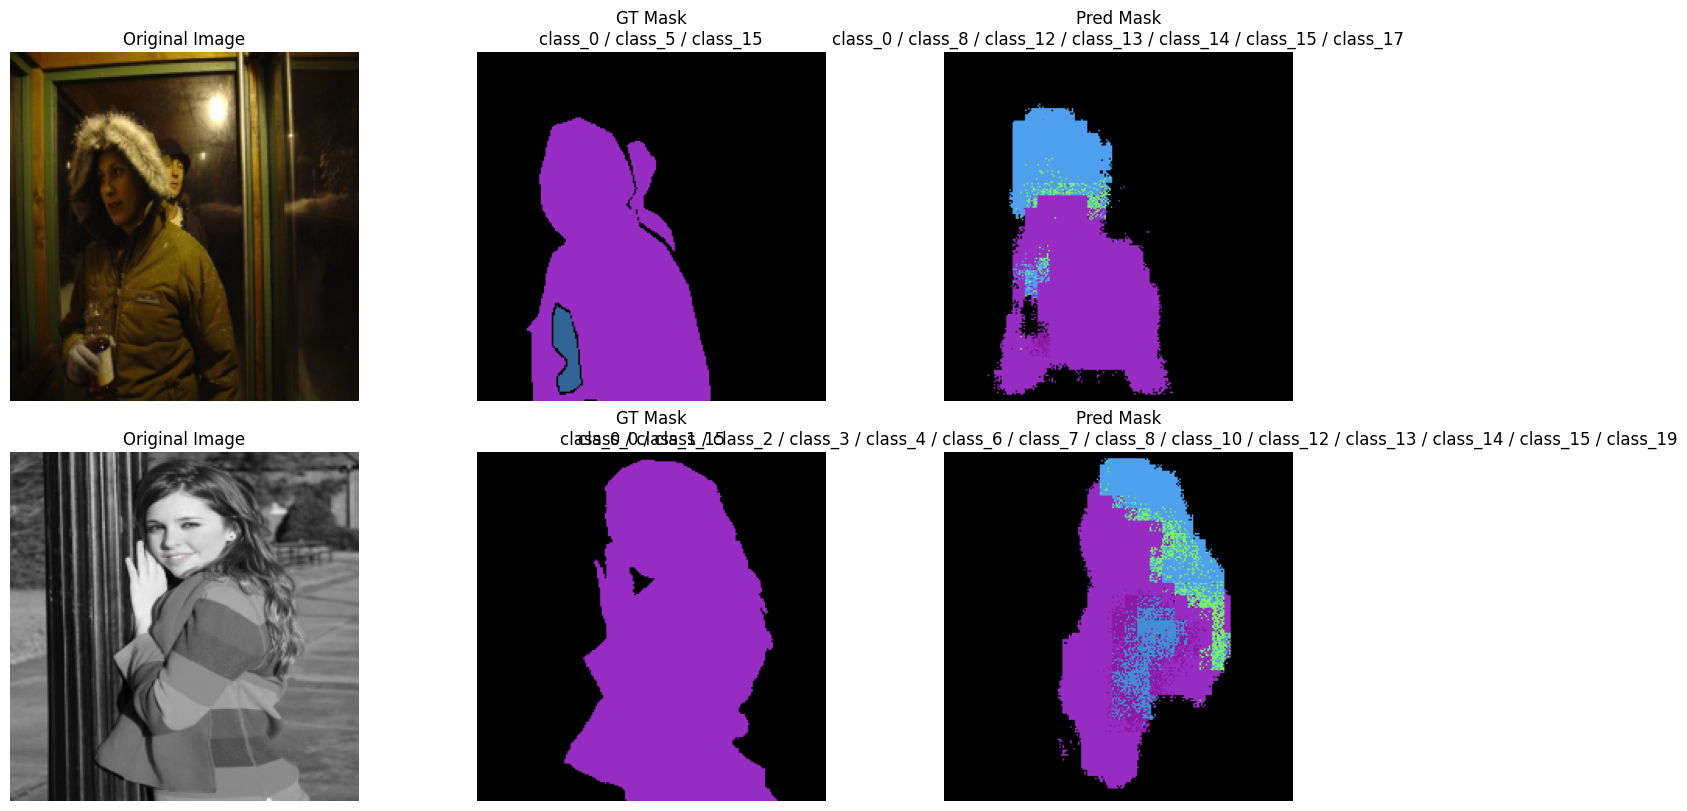

In [25]:
with torch.no_grad():
    model.eval()
    images, masks = next(iter(test_dataloader))
    outputs = model(images.to(device))
    outputs = outputs.argmax(dim=1).to("cpu")
    draw_mask(images, masks, outputs, 2)

In [ ]:
fcn = FCN8s()

# print(fcn.vgg16)
print(fcn.pool3)
print(fcn.pool4)
print(fcn.pool5)